### **Классификация по тональности**

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.

**Часть 1. Анализ текстов**

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограммы длин слов в символах и в словах
3. Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf-idf для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

**Часть 2. Тематическое моделирование**

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

**Часть 3. Классификация текстов**

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных
n-грам.
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: tf-idf преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.


###**Часть 1. Анализ текстов**

In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%pylab inline

from sklearn.feature_extraction.text import CountVectorizer

Populating the interactive namespace from numpy and matplotlib


**1. Посчитайте количество отзывов в разных городах и на разные банки**


In [ ]:
#Загружаем данные
responses = []
with bz2.BZ2File('/content/banki_responses.json.bz2','r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:20, 1430.20it/s]


In [ ]:
#Посмотрим на пример отзыва
responses[0]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Жалоба',
 'num_comments': 0,
 'bank_license': 'лицензия № 2562',
 'author': 'uhnov1',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-08 12:50:54',
 'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удо

Из-за ограничений ОЗУ затруднительно выполнение дальнейших пунктов задания (в частности, лемматизация и частотный подсчет).

В связи с этим для работы возьмем половину датасета.

In [ ]:
#Cоздаем датафрейм для дальнейшей работы
df_bank_reviews = pd.DataFrame(responses[:(len(responses) // 2)])
df_bank_reviews.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [ ]:
#Посмотрим на общую информацию по датафрейму
df_bank_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76749 entries, 0 to 76748
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                76749 non-null  object 
 1   rating_not_checked  76749 non-null  bool   
 2   title               76749 non-null  object 
 3   num_comments        76749 non-null  int64  
 4   bank_license        76748 non-null  object 
 5   author              76748 non-null  object 
 6   bank_name           76749 non-null  object 
 7   datetime            76749 non-null  object 
 8   text                76749 non-null  object 
 9   rating_grade        36299 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 5.3+ MB


**Количество отзывов в разных городах**

In [ ]:
num_reviews_city = df_bank_reviews.groupby(['city'])['text'].size().reset_index().sort_values(by='text', ascending=False)
num_reviews_city.rename(columns={'city': 'Город', 'text': 'Количество_отзывов' }, inplace=True)
num_reviews_city.head(10)

,Город,Количество_отзывов
1258,г. Москва,30785
1942,г. Санкт-Петербург,8170
605,г. Екатеринбург,1339
1523,г. Новосибирск,1309
1451,г. Нижний Новгород,1176
1857,г. Ростов-на-Дону,1143
1916,г. Самара,1010
2455,г. Челябинск,883
775,г. Казань,878
1002,г. Краснодар,781


**Количество отзывов на разные банки**

In [ ]:
num_reviews_banks = df_bank_reviews.groupby(['bank_name'])['text'].size().reset_index().sort_values(by='text', ascending=False)
num_reviews_banks.rename(columns={'bank_name': 'Банк', 'text': 'Количество_отзывов' }, inplace=True)
num_reviews_banks.head(10)

,Банк,Количество_отзывов
361,Сбербанк России,13358
25,Альфа-Банк,4954
446,Хоум Кредит Банк,4427
81,ВТБ 24,3773
345,Русский Стандарт,3693
251,Национальный Банк «Траст»,3072
405,Тинькофф Банк,2983
103,Восточный Экспресс Банк,2002
269,ОТП Банк,1762
320,Ренессанс Кредит,1689


**Количество отзывов в разных городах и на разные банки**

In [ ]:
num_reviews_cities_banks = df_bank_reviews.groupby(['city', 'bank_name'])['text'].size().reset_index().sort_values(by='text', ascending=False)
num_reviews_cities_banks.rename(columns={'city': 'Город', 'bank_name': 'Банк', 'text': 'Количество_отзывов' }, inplace=True)
num_reviews_cities_banks.head(20)

,Город,Банк,Количество_отзывов
5069,г. Москва,Сбербанк России,4502
4831,г. Москва,Альфа-Банк,2151
4870,г. Москва,ВТБ 24,1473
5101,г. Москва,Тинькофф Банк,1415
4974,г. Москва,Московский Кредитный Банк,1406
5055,г. Москва,Русский Стандарт,1405
8177,г. Санкт-Петербург,Сбербанк России,1321
5132,г. Москва,Хоум Кредит Банк,1309
4985,г. Москва,Национальный Банк «Траст»,1174
4855,г. Москва,Банк Москвы,712


**2. Постройте гистограммы длин слов в символах и в словах**


In [ ]:
#подключаем встроенный модуль работы со строками
import string
#подключаем регулярные выражения
import re

def del_punct_symb(row):
    # переводим символы в нижний регистр, чтобы всё было одинаково
    row = row.lower()
    # добавляем к стандартным знакам пунктуации кавычки и многоточие
    spec_chars = string.punctuation + '«»\t—…’'
    # очищаем текст от знаков препинания
    row = "".join([ch for ch in row if ch not in spec_chars])
    # меняем переносы строк на пробелы
    row = re.sub('\n', ' ', row)
    # убираем из текста цифры
    row = "".join([ch for ch in row if ch not in string.digits])
    return row

In [ ]:
df_bank_reviews['text'] = df_bank_reviews['text'].apply(del_punct_symb)
df_bank_reviews.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,добрый день я не являюсь клиентом банка и пору...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,доброго дня являюсь держателем зарплатной карт...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,здравствуйте дублирую свое заявление от в до...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,добрый день я открыл расчетный счет в сбербанк...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,г взяла кредит в вашем банке заявленная мною ...,NaN


In [ ]:
#Посмотрим на пример отзыва после обработки текста
df_bank_reviews['text'].iloc[0]

'добрый день я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь какимлибо другим лицом письменно  оформившим отношения с банком по поводу урегулирования чьейлибо  задолженности  начиная с марта  года начали приходить бесконечные письма из ооо примо коллектна мой адрес город москва уваровский переулок дом  квартира  с угрозами о возбуждении уголовного дела в отношении гражданина филиппова эдуарда владимировича который уклоняется от уплаты взятых им кредитов договор №  от  года и договор №  от  года со всей ответственностью\xa0 хочу вас заверить что вышеуказанный гражданин которого вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован каким образом вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно\xa0 и почему по вашей милости я должна переживать и бояться за себе и свое имущество письма доставляют мне серьезные неудобства нарушают мои гражданские права а также на

**Построение гистограммы количества символов в отзыве**

In [ ]:
df_bank_reviews['Кол-во символов в отзыве'] = df_bank_reviews['text'].apply(lambda x: len(x))
df_bank_reviews.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,Кол-во символов в отзыве
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,добрый день я не являюсь клиентом банка и пору...,NaN,1448
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,доброго дня являюсь держателем зарплатной карт...,NaN,982
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,здравствуйте дублирую свое заявление от в до...,NaN,512
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,добрый день я открыл расчетный счет в сбербанк...,NaN,705
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,г взяла кредит в вашем банке заявленная мною ...,NaN,1755


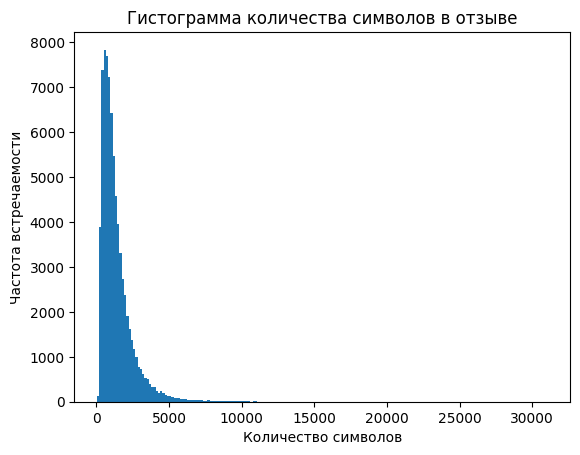

In [ ]:
df_bank_reviews['Кол-во символов в отзыве'].plot.hist(bins=200)

plt.xlabel('Количество символов') #Подпись для оси х
plt.ylabel('Частота встречаемости') #Подпись для оси y
plt.title('Гистограмма количества символов в отзыве') #Название
plt.show()

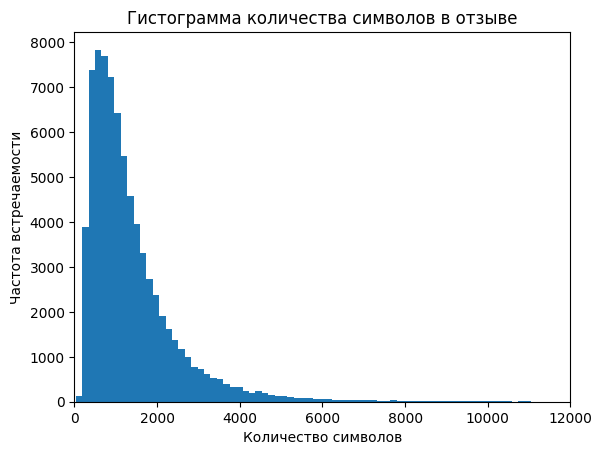

In [ ]:
#Ограничим на графике значения оси Х
df_bank_reviews['Кол-во символов в отзыве'].plot.hist(bins=200)

plt.xlim(0, 12000)
plt.xlabel('Количество символов') #Подпись для оси х
plt.ylabel('Частота встречаемости') #Подпись для оси y
plt.title('Гистограмма количества символов в отзыве') #Название
plt.show()

Как следует из графика, объем отзывов чаще всего составляет около 1000 символов, а большинство отзывов уклабывается в диапазон до 3000 символов.

Более длинные отзывы встречаются реже.

**Построение гистограммы количества слов в отзыве**

In [ ]:
df_bank_reviews['Кол-во слов в отзыве'] = df_bank_reviews['text'].apply(lambda x: len(x.split()))
df_bank_reviews.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,Кол-во символов в отзыве,Кол-во слов в отзыве
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,добрый день я не являюсь клиентом банка и пору...,NaN,1448,212
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,доброго дня являюсь держателем зарплатной карт...,NaN,982,134
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,здравствуйте дублирую свое заявление от в до...,NaN,512,81
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,добрый день я открыл расчетный счет в сбербанк...,NaN,705,119
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,г взяла кредит в вашем банке заявленная мною ...,NaN,1755,285


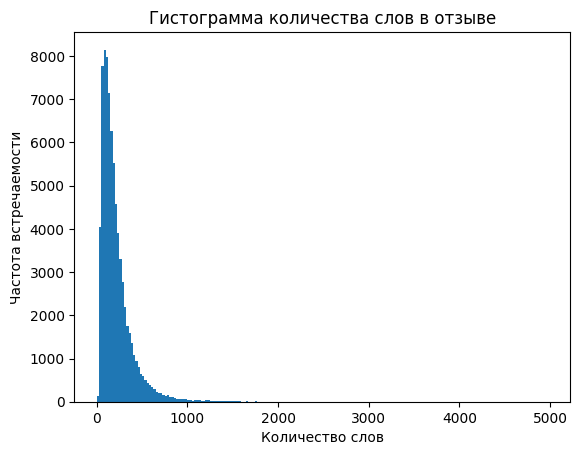

In [ ]:
df_bank_reviews['Кол-во слов в отзыве'].plot.hist(bins=200)

plt.xlabel('Количество слов')
plt.ylabel('Частота встречаемости')
plt.title('Гистограмма количества слов в отзыве')
plt.show()

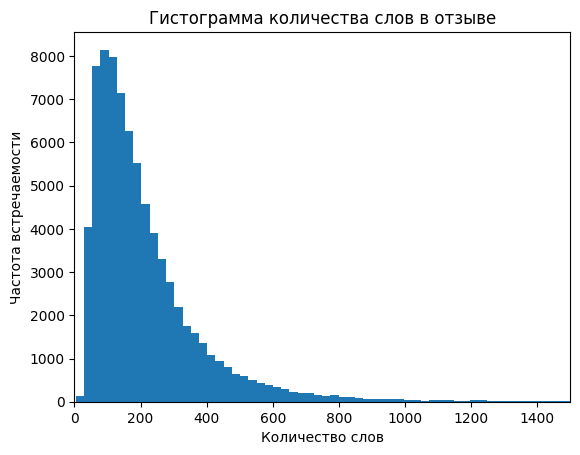

In [ ]:
#Ограничим на графике значения оси Х
df_bank_reviews['Кол-во слов в отзыве'].plot.hist(bins=200)

plt.xlim(0, 1500)
plt.xlabel('Количество слов')
plt.ylabel('Частота встречаемости')
plt.title('Гистограмма количества слов в отзыве')
plt.show()

Как следует из графика, объем отзывов чаще всего составляет около 150-200 слов, а большинство отзывов уклабывается в диапазон до 500 слов.

Более длинные отзывы встречаются реже.

**3. Найдите 10 самых частых:**
- слов
- слов без стоп-слов
- лемм
- существительных


In [ ]:
#Создадим список отзывов
all_reviews = df_bank_reviews['text'].tolist()

In [ ]:
#Объединим все отзывы в единый текст
def join_strs_better(strs):
    return ' '.join(strs)

all_reviews_full = join_strs_better(all_reviews)

**Топ 10 слов по частоте**


In [ ]:
# из библиотеки обработки текста подключаем модуль для токенизации слов
from nltk import word_tokenize
nltk.download('punkt_tab')

# токенизируем текст
text_tokens = word_tokenize(all_reviews_full)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# переводим токены в текстовый формат
all_reviews_full_tokens = nltk.Text(text_tokens)

In [ ]:
# подключаем статистику
from nltk.probability import FreqDist

# и считаем слова в тексте по популярности
fdist = FreqDist(all_reviews_full_tokens)

In [ ]:
# выводим первые 10 популярных слов
print(fdist.most_common(10))

[('в', 621419), ('и', 495333), ('не', 405742), ('на', 334702), ('что', 291447), ('я', 273286), ('с', 219686), ('по', 178113), ('мне', 153515), ('банка', 132118)]


**Топ 10 слов по частоте (без стоп-слов)**

In [ ]:
# подключаем модуль со стоп-словами
from nltk.corpus import stopwords
nltk.download('stopwords')

# добавляем русские слова
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# перестраиваем токены, не учитывая стоп-слова
text_tokens = [token.strip() for token in text_tokens if token not in russian_stopwords]

# снова приводим токены к текстовому виду
all_reviews_full_tokens = nltk.Text(text_tokens)

# считаем заново частоту слов
fdist_sw = FreqDist(all_reviews_full_tokens)

# показываем самые популярные
print(fdist_sw.most_common(10))

[('банка', 132118), ('банк', 97855), ('это', 83019), ('деньги', 60250), ('карты', 46344), ('карту', 46320), ('кредит', 39342), ('день', 38327), ('заявление', 33435), ('отделение', 31236)]


In [ ]:
def remove_stopwords(text, stopwords=russian_stopwords):
    try:
        return " ".join([token for token in text.split() if not token in stopwords])
    except:
        return ""

In [ ]:
df_bank_reviews['text_no_stopwords'] = df_bank_reviews.text.apply(remove_stopwords)
df_bank_reviews.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,Кол-во символов в отзыве,Кол-во слов в отзыве,text_no_stopwords
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,добрый день я не являюсь клиентом банка и пору...,NaN,1448,212,добрый день являюсь клиентом банка поручителем...
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,доброго дня являюсь держателем зарплатной карт...,NaN,982,134,доброго дня являюсь держателем зарплатной карт...
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,здравствуйте дублирую свое заявление от в до...,NaN,512,81,здравствуйте дублирую свое заявление можайский...
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,добрый день я открыл расчетный счет в сбербанк...,NaN,705,119,добрый день открыл расчетный счет сбербанке юр...
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,г взяла кредит в вашем банке заявленная мною ...,NaN,1755,285,г взяла кредит вашем банке заявленная мною сум...


**Топ 10 лемм по частоте**

In [ ]:
!pip install pymystem3


In [ ]:
from pymystem3 import Mystem

m = Mystem()

def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()
    except:
        return " "

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
df_bank_reviews['text_lemmas'] = df_bank_reviews.text_no_stopwords.apply(lemmatize)
df_bank_reviews.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,Кол-во символов в отзыве,Кол-во слов в отзыве,text_no_stopwords,text_lemmas
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,добрый день я не являюсь клиентом банка и пору...,NaN,1448,212,добрый день являюсь клиентом банка поручителем...,добрый день являться клиент банк поручитель кр...
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,доброго дня являюсь держателем зарплатной карт...,NaN,982,134,доброго дня являюсь держателем зарплатной карт...,добрый день являться держатель зарплатной карт...
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,здравствуйте дублирую свое заявление от в до...,NaN,512,81,здравствуйте дублирую свое заявление можайский...,здравствовать дублировать свой заявление можай...
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,добрый день я открыл расчетный счет в сбербанк...,NaN,705,119,добрый день открыл расчетный счет сбербанке юр...,добрый день открывать расчетный счет сбербанк ...
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,г взяла кредит в вашем банке заявленная мною ...,NaN,1755,285,г взяла кредит вашем банке заявленная мною сум...,г взять кредит ваш банк заявлять я сумма т руб...


In [ ]:
from collections import Counter

cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]

for index, row in tqdm(df_bank_reviews.iterrows(), total = len(df_bank_reviews)):
    tokens = row['text_lemmas'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    tokens_all+=tokens
    n_tokens.append(sum(cnt.values()))

for i in cnt.most_common(10):
    print(i)

100%|██████████| 76749/76749 [00:15<00:00, 4819.49it/s]

('банк', 287839)
('карта', 149117)
('мой', 85268)
('день', 83335)
('деньги', 81825)
('кредит', 77599)
('это', 76748)
('который', 72569)
('сотрудник', 70580)
('счет', 65243)


**Топ 10 существительных по частоте**

In [ ]:
!pip install pymorphy2

from pymorphy2 import MorphAnalyzer

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 68.6 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=f439eca83e2a8bce9e34b4fee1b01d4f3c60d514405ebce3c2fff9731f964128
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
def to_nouns(text, mystem=m):
    m = MorphAnalyzer()
    try:
        return " ".join([noun for noun in text.split() if m.parse(noun)[0].tag.POS =='NOUN'])
    except:
        return []

to_nouns(df_bank_reviews['text_lemmas'].iloc[1])

'день держатель карта сбербанк россия год фамилия банк документ копия паспорт свидетельство брак карта фамилия муж токарева мария александровна секлетина необходимость услуга сбербанк страница карта специалист отделение сбербанк база банк фамилия секлетина скан документ контакт звонок время ситуация база секлетина карта фамилия токарева связь истечение срок обслуживание документ копия паспорт свидетельство брак результат ноль ситуация уважение токарев мария александровна'

In [ ]:
from multiprocessing import Pool

with Pool() as p:
    df_bank_reviews['nouns']=p.map(to_nouns,df_bank_reviews.text_lemmas)

In [ ]:
cnt_noun = Counter()
n_types_noun = []
n_tokens_noun= []
tokens_noun = []
tokens_all_noun=[]

for index, row in tqdm(df_bank_reviews.iterrows(), total = len(df_bank_reviews)):
    tokens = row['nouns'].split()
    cnt_noun.update(tokens)
    n_types_noun.append(len(cnt))
    tokens_all_noun+=tokens
    n_tokens_noun.append(sum(cnt.values()))

for i in cnt_noun.most_common(10):
    print(i)

100%|██████████| 76749/76749 [00:14<00:00, 5309.84it/s]

('банк', 287839)
('карта', 149117)
('день', 83335)
('деньги', 81825)
('кредит', 77599)
('сотрудник', 70580)
('счет', 65243)
('отделение', 65077)
('клиент', 63252)
('сумма', 55818)


**4. Постройте кривые Ципфа и Хипса**


**Построение кривой Ципфа**

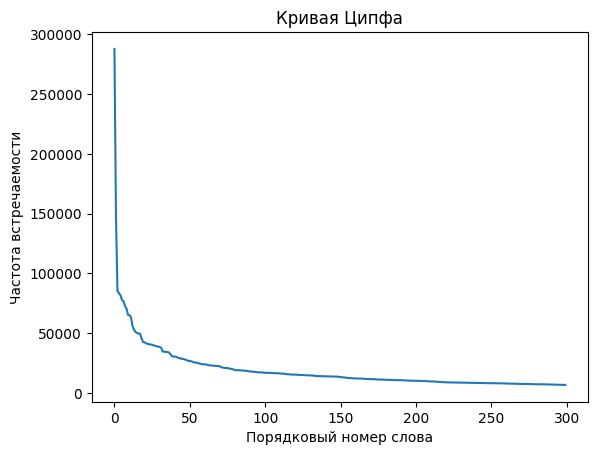

In [ ]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(range(300), freqs[:300])

plt.xlabel('Порядковый номер слова')
plt.ylabel('Частота встречаемости')
plt.title('Кривая Ципфа')
plt.show()

По закону Ципфа, если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

На графике отображена частотность существительных в корпусе. Распределение соответствует закону Ципфа.

**Построение кривой Хипса**


In [ ]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
cnt_1 = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df_bank_reviews.iterrows(), total = len(df_bank_reviews)):
    tokens = word_tokenize(row['text'])
    cnt_1.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt_1))
    n_tokens.append(sum(cnt_1.values()))

100%|██████████| 76749/76749 [02:01<00:00, 630.98it/s]


In [ ]:
fig, ax = plt.subplots()
ax.plot(n_tokens.append(sum(list(cnt.values()))), n_words)

plt.xlabel('Объем корпуса')
plt.ylabel('Количество уникальных слов')
plt.title('Кривая Хипса')
plt.show()

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

**5. Ответьте на следующие вопросы:**
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?


При ответе на этот вопрос лучше использовать информацию на основе всех лемматизированных токенов.

Однако из-за огрничений ОЗУ, мы такой список не получили.

Далее будет использовать информацию, полученную при анализе существительных.

In [ ]:
word_1 = "сотрудник"
word_2 = "клиент"

print(f'Слово "{word_1}" встречается {cnt_noun[word_1]} раз(-а).\n')
print(f'Слово "{word_2}" встречается {cnt_noun[word_2]} раз(-а).\n')

if cnt_noun[word_1] > cnt_noun[word_2]:
    print(f'Слово "{word_1}" встречается чаще слова "{word_2}".')
else:
    print(f'Слово "{word_2}" встречается чаще слова "{word_1}".')

Слово "сотрудник" встречается 70580 раз(-а).

Слово "клиент" встречается 63252 раз(-а).

Слово "сотрудник" встречается чаще слова "клиент".


In [ ]:
word_3 = "мошенничество"
word_4 = "доверие"

print(f'Слово "{word_3}" встречается {cnt_noun[word_3]} раз(-а).\n')
print(f'Слово "{word_4}" встречается {cnt_noun[word_4]} раз(-а).\n')

Слово "мошенничество" встречается 1692 раз(-а).

Слово "доверие" встречается 1010 раз(-а).



**6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf-idf для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)**

In [ ]:
#Создадим датафрейм только с rating_grade равным 1 или 5
df_rat_1 = df_bank_reviews.loc[df_bank_reviews['rating_grade'] == 1]
df_rat_5 = df_bank_reviews.loc[df_bank_reviews['rating_grade'] == 5]

In [ ]:
print(df_rat_1.info())
print(df_rat_5.info())

<class 'pandas.core.frame.DataFrame'>
Index: 21318 entries, 19 to 76748
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   city                      21318 non-null  object 
 1   rating_not_checked        21318 non-null  bool   
 2   title                     21318 non-null  object 
 3   num_comments              21318 non-null  int64  
 4   bank_license              21318 non-null  object 
 5   author                    21318 non-null  object 
 6   bank_name                 21318 non-null  object 
 7   datetime                  21318 non-null  object 
 8   text                      21318 non-null  object 
 9   rating_grade              21318 non-null  float64
 10  Кол-во символов в отзыве  21318 non-null  int64  
 11  Кол-во слов в отзыве      21318 non-null  int64  
 12  text_no_stopwords         21318 non-null  object 
 13  text_lemmas               21318 non-null  object 
 14  nouns     

In [ ]:
num=len(df_rat_5['rating_grade'])

df_sample = df_rat_5.copy()

df_sample = pd.concat([df_sample, df_rat_1.sample(n=num)], axis = 0)

df_sample.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,Кол-во символов в отзыве,Кол-во слов в отзыве,text_no_stopwords,text_lemmas,nouns
98,г. Санкт-Петербург,False,"Хорошо, когда проблемы решаются",0,лицензия № 1073,apka45,Русславбанк,2015-06-03 17:40:38,досрочно закрывали вклады перед отпуском жена ...,5.0,365,54,досрочно закрывали вклады отпуском жена заказы...,досрочно закрывать вклад отпуск жена заказыват...,вклад отпуск жена сотрудник банк спб ленсовет ...
122,г. Нижний Новгород,False,Изменяют проценты по уже открытому договору вк...,3,лицензия № 226,20157673,РосинтерБанк,2015-06-04 09:38:18,хотел открыть вклад доходный под год процент...,5.0,1094,171,хотел открыть вклад доходный год проценты начи...,хотеть открывать вклад доходный год процент на...,вклад год процент лесенка месяц месяц месяц ус...
157,г. Москва,False,"Отделение Марксистская, дом 5: спасибо за помощь!",0,лицензия № 1623,ospar,ВТБ 24,2015-06-04 22:58:38,вчера июня просидев в очереди более х часов н...,5.0,800,124,вчера июня просидев очереди х часов получение ...,вчера июнь просиживать очередь х час получение...,июнь очередь час получение выплата банк админи...
259,г. Москва,False,Хорошее обслуживание,0,лицензия № 3206,ser-gyr,Соверен Банк,2015-06-02 18:23:41,сегодня открывал вклад в этом банке очередь бы...,5.0,603,86,сегодня открывал вклад банке очередь одного кл...,сегодня открывать вклад банк очередь один клие...,вклад банк очередь клиент зав отделение участи...
266,г. Москва,False,Моя история получения кредита в Ренессанс Кред...,1,лицензия № 3354,SkaIa,Ренессанс Кредит,2015-06-03 02:03:28,моя история получения кредита в ренессанс кред...,5.0,2034,308,история получения кредита ренессанс кредит бан...,история получение кредит ренессанс кредит банк...,история получение кредит ренессанс кредит банк...


In [ ]:
df_sample.rating_grade.value_counts()

,count
rating_grade,
5.0,4254
1.0,4254


In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также', 'т', 'д', 'г']
def remove_stopwords(text, mystopwords=mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_sample['text_tokinized_stop_words'] = df_sample.text.str.lower().apply(remove_stopwords)

In [ ]:
tokens_by_text = []

for rating in df_sample.rating_grade.unique():
    tokens=[]
    sample=df_sample[df_sample['rating_grade']==rating]

    for i in range(len(sample)):
        tokens += sample.text_tokinized_stop_words.iloc[i].split()

    tokens_by_text.append(tokens)

**Поиск ключевых униграмм**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0.0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_text])
feature_names = tfidf.get_feature_names_out()
tfidf_ranking_5 = []
tfidf_ranking_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_5.append(phrase)

text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_1.append(phrase)

In [ ]:
rank = pd.DataFrame({'tfidf_ranking_5': tfidf_ranking_5,'tfidf_ranking_1': tfidf_ranking_1})
rank.head(10)

,tfidf_ranking_5,tfidf_ranking_1
0,банка,банка
1,банк,банк
2,деньги,очень
3,карту,спасибо
4,карты,деньги
5,заявление,карту
6,отделение,банке
7,кредит,день
8,день,время
9,дней,карты


**Убираем пересечения**

In [ ]:
rank['tfidf_ranking_5_without_1']=rank.tfidf_ranking_5[~rank.tfidf_ranking_5.isin(rank.tfidf_ranking_1)]
rank['tfidf_ranking_1_without_5']=rank.tfidf_ranking_1[~rank.tfidf_ranking_1.isin(rank.tfidf_ranking_5)]

In [ ]:
rank.iloc[:,-2:].dropna()

,tfidf_ranking_5_without_1,tfidf_ranking_1_without_5
14,ответ,хочу
22,сказали,сразу
24,сотрудник,вклада
48,договора,очереди
50,договор,ткс
51,прошу,работы
54,вообще,решил
57,получить,сказать
62,срок,офисе
63,девушка,офиса


**Поиск биграмм**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0.0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_text])
feature_names = tfidf.get_feature_names_out()
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)

text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase)

In [ ]:
rankings = pd.DataFrame({'tfidf_ranking_rank_is_5': tfidf_ranking_rank_is_5,'tfidf_ranking_rank_is_1': tfidf_ranking_rank_is_1})
rankings.head(10)

,tfidf_ranking_rank_is_5,tfidf_ranking_rank_is_1
0,отделение банка,добрый день
1,денежных средств,являюсь клиентом
2,добрый день,следующий день
3,денежные средства,клиентом банка
4,сих пор,хочу выразить
5,горячую линию,выразить благодарность
6,сотрудник банка,очень быстро
7,следующий день,большое спасибо
8,горячей линии,хочу поблагодарить
9,сотрудники банка,других банках


In [ ]:
rankings['tfidf_ranking_rank_is_5_without_1']=rankings.tfidf_ranking_rank_is_5[~rankings.tfidf_ranking_rank_is_5.isin(rankings.tfidf_ranking_rank_is_1)]
rankings['tfidf_ranking_rank_is_1_without_5']=rankings.tfidf_ranking_rank_is_1[~rankings.tfidf_ranking_rank_is_1.isin(rankings.tfidf_ranking_rank_is_5)]

In [ ]:
rankings.iloc[:,-2:].dropna()

,tfidf_ranking_rank_is_5_without_1,tfidf_ranking_rank_is_1_without_5
8,горячей линии,хочу поблагодарить
10,написать заявление,огромное спасибо
11,рабочих дней,очень удобно
16,службу поддержки,хочу отметить
19,мои деньги,уважаемый автор
21,свои деньги,хочу сказать
22,написал заявление,открыть вклад
23,таким образом,отдельное спасибо
26,досрочное погашение,огромную благодарность
29,отделение сбербанка,интернет банк


### **Часть 2. Тематическое моделирование**

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.


In [ ]:
import gensim.corpora as corpora
from gensim.models import ldamodel

In [ ]:
texts = [df_bank_reviews['text_lemmas'].iloc[i].split() for i in range(len(df_bank_reviews))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
lda = ldamodel.LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=20,
                        alpha='auto',
                        eta='auto',
                        iterations = 20,
                        passes = 5)

In [ ]:
# 20 тем, выборка 5
lda.show_topics(5)

[(4,
  '0.062*"служба" + 0.048*"поддержка" + 0.029*"заблокировать" + 0.029*"кошелек" + 0.024*"безопасность" + 0.023*"блокировка" + 0.022*"qiwi" + 0.021*"киви" + 0.016*"номер" + 0.015*"ответ"'),
 (7,
  '0.052*"документ" + 0.032*"справка" + 0.028*"заявка" + 0.028*"кредит" + 0.023*"менеджер" + 0.020*"квартира" + 0.019*"ипотека" + 0.015*"ипотечный" + 0.014*"сделка" + 0.013*"втб"'),
 (1,
  '0.030*"сказать" + 0.017*"приходить" + 0.017*"девушка" + 0.017*"говорить" + 0.014*"позвонить" + 0.013*"банк" + 0.013*"заявка" + 0.013*"спрашивать" + 0.011*"звонить" + 0.010*"это"'),
 (11,
  '0.050*"день" + 0.023*"банк" + 0.020*"отделение" + 0.017*"позвонить" + 0.015*"сказать" + 0.014*"заявление" + 0.013*"ответ" + 0.013*"звонить" + 0.013*"неделя" + 0.012*"течение"'),
 (14,
  '0.043*"банк" + 0.028*"это" + 0.017*"клиент" + 0.013*"свой" + 0.012*"такой" + 0.012*"который" + 0.008*"просто" + 0.008*"другой" + 0.007*"этот" + 0.007*"время"')]

Интерпретация тем:
1. Блокировка киви-кошелька
2. Ипотечное кредитование
3. Консультация по банковским услугам
4. Срок ответа по заявлению
5. Обращение клиента в банк

In [ ]:
lda10 = ldamodel.LdaModel(corpus=corpus,
                          id2word=dictionary,
                          num_topics=10,
                          alpha='auto',
                          eta='auto',
                          iterations = 20,
                          passes = 5)

In [ ]:
# 10 тем, выборка из 5
lda10.show_topics(5)

[(2,
  '0.077*"вклад" + 0.049*"банк" + 0.028*"открывать" + 0.028*"счет" + 0.019*"деньги" + 0.016*"процент" + 0.013*"открытие" + 0.013*"договор" + 0.013*"сумма" + 0.011*"условие"'),
 (7,
  '0.034*"банк" + 0.016*"договор" + 0.015*"мой" + 0.013*"заявление" + 0.013*"г" + 0.012*"данный" + 0.012*"документ" + 0.009*"ответ" + 0.008*"получать" + 0.008*"средство"'),
 (9,
  '0.116*"карта" + 0.029*"банк" + 0.012*"кредитный" + 0.010*"услуга" + 0.009*"получать" + 0.009*"это" + 0.008*"пользоваться" + 0.008*"лимит" + 0.008*"который" + 0.008*"год"'),
 (5,
  '0.039*"банк" + 0.016*"клиент" + 0.015*"очень" + 0.014*"это" + 0.009*"свой" + 0.008*"который" + 0.008*"работа" + 0.007*"такой" + 0.006*"время" + 0.006*"год"'),
 (6,
  '0.021*"день" + 0.020*"сказать" + 0.019*"банк" + 0.013*"отделение" + 0.012*"позвонить" + 0.011*"приходить" + 0.010*"заявление" + 0.010*"это" + 0.010*"заявка" + 0.010*"деньги"')]

Интерпретация тем:
1. Открытие вклада
2. Ответ по заявлению клиента
3. Условия кредитования
4. Порядок обслуживания
5. Заявка на получение кредита

### **Часть 3. Классификация текстов**

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).


***Примечание:*** Поскольку объема ОЗУ не достаточно для продолжения работы в рамках данной сессии, сохраним датафрейм для работы над 3 заданием.

In [ ]:
df_sample.to_csv('df_sample.csv', encoding='utf-8')



**1.** Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.


In [5]:
df_sample = pd.read_csv('/content/df_sample.csv')
df_sample.head()

,Unnamed: 0,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,Кол-во символов в отзыве,Кол-во слов в отзыве,text_no_stopwords,text_lemmas,nouns,text_tokinized_stop_words
0,98,г. Санкт-Петербург,False,"Хорошо, когда проблемы решаются",0,лицензия № 1073,apka45,Русславбанк,2015-06-03 17:40:38,досрочно закрывали вклады перед отпуском жена ...,5.0,365,54,досрочно закрывали вклады отпуском жена заказы...,досрочно закрывать вклад отпуск жена заказыват...,вклад отпуск жена сотрудник банк спб ленсовет ...,досрочно закрывали вклады отпуском жена заказы...
1,122,г. Нижний Новгород,False,Изменяют проценты по уже открытому договору вк...,3,лицензия № 226,20157673,РосинтерБанк,2015-06-04 09:38:18,хотел открыть вклад доходный под год процент...,5.0,1094,171,хотел открыть вклад доходный год проценты начи...,хотеть открывать вклад доходный год процент на...,вклад год процент лесенка месяц месяц месяц ус...,хотел открыть вклад доходный год проценты начи...
2,157,г. Москва,False,"Отделение Марксистская, дом 5: спасибо за помощь!",0,лицензия № 1623,ospar,ВТБ 24,2015-06-04 22:58:38,вчера июня просидев в очереди более х часов н...,5.0,800,124,вчера июня просидев очереди х часов получение ...,вчера июнь просиживать очередь х час получение...,июнь очередь час получение выплата банк админи...,вчера июня просидев очереди х часов получение ...
3,259,г. Москва,False,Хорошее обслуживание,0,лицензия № 3206,ser-gyr,Соверен Банк,2015-06-02 18:23:41,сегодня открывал вклад в этом банке очередь бы...,5.0,603,86,сегодня открывал вклад банке очередь одного кл...,сегодня открывать вклад банк очередь один клие...,вклад банк очередь клиент зав отделение участи...,сегодня открывал вклад банке очередь одного кл...
4,266,г. Москва,False,Моя история получения кредита в Ренессанс Кред...,1,лицензия № 3354,SkaIa,Ренессанс Кредит,2015-06-03 02:03:28,моя история получения кредита в ренессанс кред...,5.0,2034,308,история получения кредита ренессанс кредит бан...,история получение кредит ренессанс кредит банк...,история получение кредит ренессанс кредит банк...,история получения кредита ренессанс кредит бан...


In [6]:
df_sample.rating_grade.value_counts()

,count
rating_grade,
5.0,4254
1.0,4254


In [7]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8508 entries, 0 to 8507
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 8508 non-null   int64  
 1   city                       8508 non-null   object 
 2   rating_not_checked         8508 non-null   bool   
 3   title                      8465 non-null   object 
 4   num_comments               8508 non-null   int64  
 5   bank_license               8508 non-null   object 
 6   author                     8508 non-null   object 
 7   bank_name                  8508 non-null   object 
 8   datetime                   8508 non-null   object 
 9   text                       8508 non-null   object 
 10  rating_grade               8508 non-null   float64
 11  Кол-во символов в отзыве   8508 non-null   int64  
 12  Кол-во слов в отзыве       8508 non-null   int64  
 13  text_no_stopwords          8508 non-null   objec

In [8]:
X = df_sample['text_lemmas'].values
y = df_sample.rating_grade.values

In [9]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**2.** Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных
n-грам.


In [14]:
clf_countvectorized = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', LogisticRegression())]
)

param_distributions = {
    'vect__analyzer': ['word','char'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3)),
    'clf__C': np.logspace(-3,3,7),
    'clf__penalty': ['l1','l2']
}

scores=['accuracy', 'f1']

In [15]:
rs_cntv = RandomizedSearchCV(
    clf_countvectorized,
    param_distributions,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [16]:
rs_cntv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyth

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('clf', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'clf__penalty': ['l1', 'l2'],
                                        'vect__analyzer': ['word', 'char'],
                                        'vect__max_df': (0.5, 0.75, 1.0),
                                        'vect__ngram_range': ((1, 1), (2, 2),
                                                              (3, 3))},
                   random_state=42, refit='accuracy',
                   scoring=['accuracy', 'f1'], verbose=1)

In [17]:
print("Best score: %0.3f" % rs_cntv.best_score_)

Best score: 0.930


In [18]:
predictions=rs_cntv.best_estimator_.predict(X_test)

In [19]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.94
Recall:      0.94
F1_score:    0.94
Accuracy:    0.94


In [20]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.94      0.93      0.94      1279
         5.0       0.93      0.94      0.94      1274

    accuracy                           0.94      2553
   macro avg       0.94      0.94      0.94      2553
weighted avg       0.94      0.94      0.94      2553



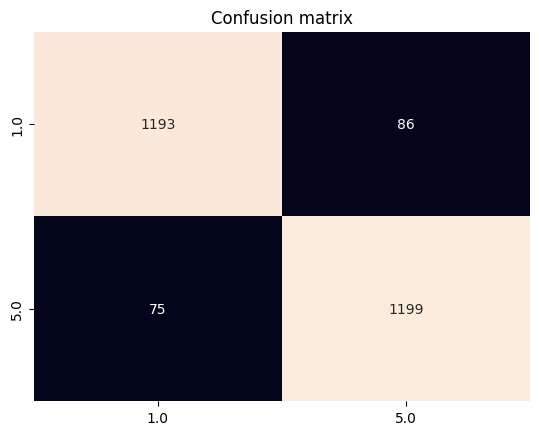

In [21]:
labels = rs_cntv.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

**3.** Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: tf-idf преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

**TF-IDF преобразование**

In [22]:
clf_tf_idf = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression())]
)

params_tf_idf={
    'vect__analyzer': ['word'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
}

scores=['accuracy','f1']

In [24]:
rs_tf_idf = RandomizedSearchCV(
    clf_tf_idf,
    param_distributions=params_tf_idf,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [25]:
rs_tf_idf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyth

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('clf', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'clf__penalty': ['l1', 'l2'],
                                        'tfidf__use_idf': (True, False),
                                        'vect__analyzer': ['word'],
                                        'vect__max_df': (0.5, 0.75, 1.0),
                                        'vect__ngram_range': [(1, 1), (2, 2),
                                                              (3, 3)]},
                   random_state=42, refit='accuracy',
                   scoring=['accuracy', 'f1'], verbose=1)

In [26]:
print("Best score: %0.3f" % rs_tf_idf.best_score_)

Best score: 0.939


In [27]:
predictions=rs_tf_idf.best_estimator_.predict(X_test)

In [28]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.95
Recall:      0.95
F1_score:    0.95
Accuracy:    0.95


In [29]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.94      0.97      0.95      1279
         5.0       0.97      0.94      0.95      1274

    accuracy                           0.95      2553
   macro avg       0.95      0.95      0.95      2553
weighted avg       0.95      0.95      0.95      2553



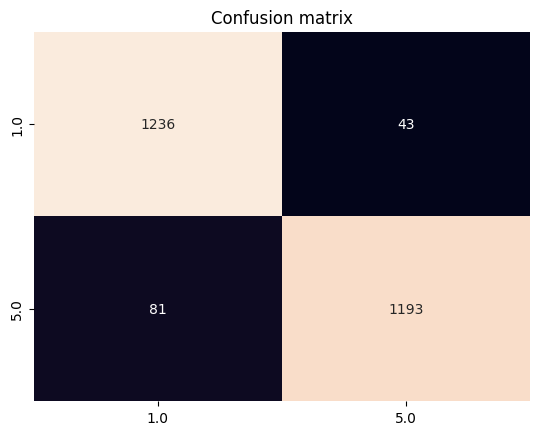

In [30]:
labels = rs_tf_idf.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

**Сингулярное разложение**

In [31]:
clf_tf_idf_TruncatedSVD = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('tsvd', TruncatedSVD()),
     ('clf', LogisticRegression())]
)

params_tf_idf_TruncatedSVD={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tsvd__n_components': [5, 10, 25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
}

scores=['accuracy','f1']

In [32]:
rs_tf_idf_TruncatedSVD = RandomizedSearchCV(
    clf_tf_idf_TruncatedSVD,
    param_distributions=params_tf_idf_TruncatedSVD,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [33]:
rs_tf_idf_TruncatedSVD.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyth

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('tsvd', TruncatedSVD()),
                                             ('clf', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'clf__penalty': ['l1', 'l2'],
                                        'tsvd__n_components': [5, 10, 25, 50,
                                                               100],
                                        'vect__analyzer': ['word'],
                                        'vect__ngram_range': [(1, 1), (2, 2),
                                                              (3, 3)]},
                   random_state=42, refit='accuracy',
                   scoring=['accuracy', 'f1'], verbose=1)

In [34]:
print("Best score: %0.3f" % rs_tf_idf_TruncatedSVD.best_score_)

Best score: 0.885


In [35]:
predictions=rs_tf_idf_TruncatedSVD.best_estimator_.predict(X_test)

In [36]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.90
Recall:      0.90
F1_score:    0.90
Accuracy:    0.90


In [37]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.89      0.91      0.90      1279
         5.0       0.91      0.88      0.89      1274

    accuracy                           0.90      2553
   macro avg       0.90      0.90      0.90      2553
weighted avg       0.90      0.90      0.90      2553



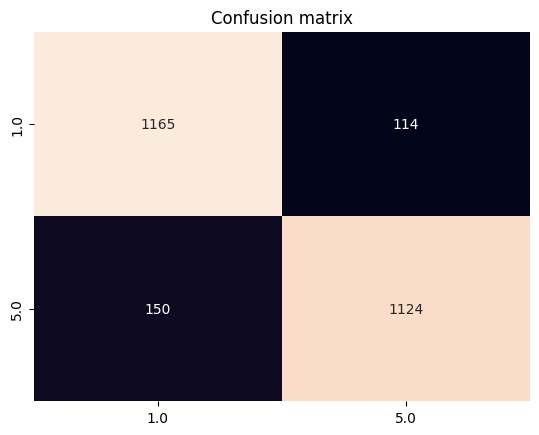

In [38]:
labels = rs_tf_idf_TruncatedSVD.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

**Тематические модели LDA**

In [43]:
clf_tf_idf_LDA = Pipeline(
    [('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('clf', LogisticRegression())]
)

params_tf_idf_LDA={
    'vect__analyzer': ['word'],
    'vect__max_df': [0.75],
    'vect__ngram_range': [(1, 1)],
    'lda__n_components' : [25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l2']
}

scores=['accuracy', 'f1']

In [44]:
rs_tf_idf_LDA = RandomizedSearchCV(
    clf_tf_idf_LDA,
    param_distributions=params_tf_idf_LDA,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [45]:
rs_tf_idf_LDA.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('lda',
                                              LatentDirichletAllocation()),
                                             ('clf', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'clf__penalty': ['l2'],
                                        'lda__n_components': [25, 50, 100],
                                        'vect__analyzer': ['word'],
                                        'vect__max_df': [0.75],
                                        'vect__ngram_range': [(1, 1)]},
                   random_state=42, refit='accuracy',
                   scoring=['accuracy', 'f1'], verbose=1)

In [46]:
print("Best score: %0.3f" % rs_tf_idf_LDA.best_score_)

Best score: 0.882


In [47]:
predictions=rs_tf_idf_LDA.best_estimator_.predict(X_test)

In [48]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.91
Recall:      0.91
F1_score:    0.91
Accuracy:    0.91


In [50]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.90      0.92      0.91      1279
         5.0       0.92      0.90      0.91      1274

    accuracy                           0.91      2553
   macro avg       0.91      0.91      0.91      2553
weighted avg       0.91      0.91      0.91      2553



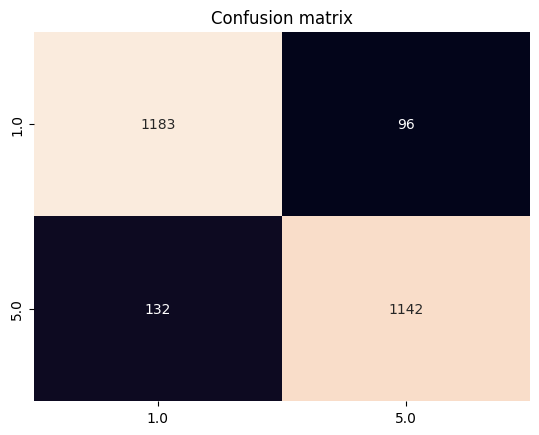

In [51]:
labels = rs_tf_idf_LDA.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

**Итоговые результаты**

In [53]:
models=['rs_cntv', 'rs_tf_idf', 'rs_tf_idf_TruncatedSVD', 'rs_tf_idf_LDA']

for model in models:
    print(model)
    predictions=eval(model).best_estimator_.predict(X_test)
    print("f1_score: {0:6.3f}\nAccuracy: {0:6.3f}\n\n".format(
        f1_score(y_test, predictions, average='macro'),
        accuracy_score(y_test, predictions)))

rs_cntv
f1_score:  0.937
Accuracy:  0.937


rs_tf_idf
f1_score:  0.951
Accuracy:  0.951


rs_tf_idf_TruncatedSVD
f1_score:  0.897
Accuracy:  0.897


rs_tf_idf_LDA
f1_score:  0.911
Accuracy:  0.911




По результатам исследования лучшее качество классификации показала модель rs_tf_idf (tf-idf преобразование (sklearn.feature_extraction.text.TfidfTransformer)).

Хуже всех справилась модель на базе семантического анализа (сингулярного разложения(sklearn.decomposition.TruncatedSVD)).